<a href="https://colab.research.google.com/github/blessingoraz/baby-cry-classifier/blob/main/01_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN for audio files
- Do some processing
- Check audio lengths/duration and sample rate
- How do you detect noise?
- Convert audio to images(checkout mel)
- Split dataset to training and test

Training
- Transfer learning
- Adjusting learning rate
- check-pointing
- Regularization and Dropout
- Data Augmentation
- Training a larger model
Using the model

In [14]:
!unzip -q /content/raw.zip -d /content/

In [15]:
from itertools import cycle
import os
import librosa
import librosa.display
import IPython.display as ipd

from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



In [23]:
base_path = '/content/raw'
classes = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
classes


['belly_pain',
 'burping',
 'cold_hot',
 'discomfort',
 'hungry',
 'lonely',
 'scared',
 'tired']

### Class imbalance (counts + bar plot)

In [24]:
counts = {c: len([f for f in os.listdir(os.path.join(base_path, c)) if f.lower().endswith((".wav", ".mp3"))])
          for c in classes}

counts

{'belly_pain': 16,
 'burping': 18,
 'cold_hot': 7,
 'discomfort': 30,
 'hungry': 382,
 'lonely': 11,
 'scared': 20,
 'tired': 28}

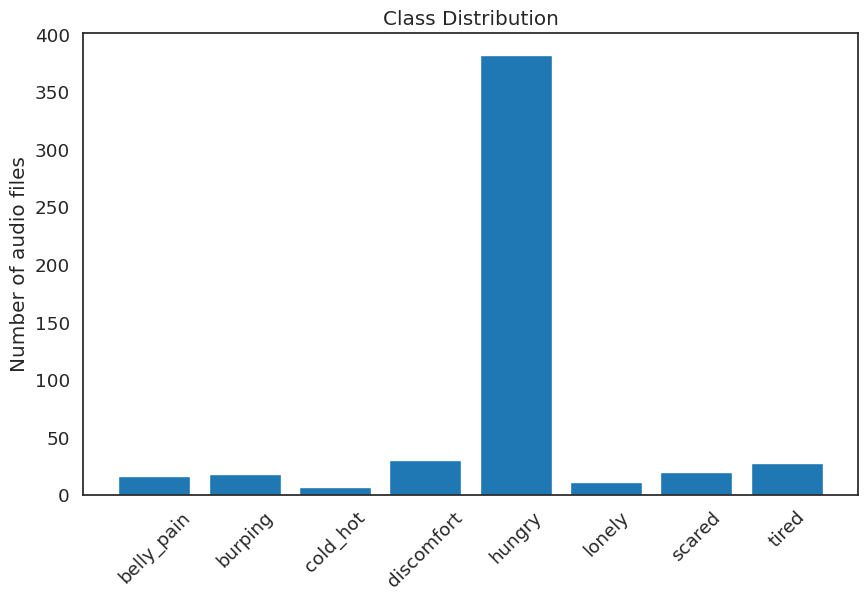

In [25]:

plt.figure(figsize=(10,6))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.ylabel("Number of audio files")
plt.show()


Dataset is imbalanced (hungry dominates). Accuracy alone will be misleading. I’ll use class weights + augmentation later.

In [26]:
rows = []
for c in classes:
    class_dir = os.path.join(base_path, c)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".wav", ".mp3")): # This check is not necessary
            rows.append({"class": c, "path": os.path.join(class_dir, fname)})

meta = pd.DataFrame(rows)
meta.head(), meta.shape


(        class                                               path
 0  belly_pain  /content/raw/belly_pain/ae5f103b-5fee-442f-bb1...
 1  belly_pain  /content/raw/belly_pain/643D64AD-B711-469A-AF6...
 2  belly_pain  /content/raw/belly_pain/69BDA5D6-0276-4462-9BF...
 3  belly_pain  /content/raw/belly_pain/643D64AD-B711-469A-AF6...
 4  belly_pain  /content/raw/belly_pain/643D64AD-B711-469A-AF6...,
 (512, 2))

In [28]:
def get_audio_info(path):
    # sr=None keeps original sampling rate
    y, sr = librosa.load(path, sr=None)
    duration = len(y) / sr
    return {
        "sampling_rate": sr,
        "duration": duration,
        "num_samples": len(y),
        "min_amp": float(np.min(y)),
        "max_amp": float(np.max(y)),
        "mean_amp": float(np.mean(y)),
        "std_amp": float(np.std(y))
    }

df = meta.copy()
df = df.assign(**df["path"].apply(get_audio_info).apply(pd.Series))
df.head()

,class,path,sampling_rate,duration,num_samples,min_amp,max_amp,mean_amp,std_amp
0,belly_pain,/content/raw/belly_pain/ae5f103b-5fee-442f-bb1...,8000.0,6.96,55680.0,-0.767456,0.613312,-0.000001,0.056354
1,belly_pain,/content/raw/belly_pain/643D64AD-B711-469A-AF6...,8000.0,7.00,56000.0,-0.471741,0.490112,-0.000006,0.028527
2,belly_pain,/content/raw/belly_pain/69BDA5D6-0276-4462-9BF...,8000.0,7.00,56000.0,-1.000000,0.999969,-0.002019,0.225891
3,belly_pain,/content/raw/belly_pain/643D64AD-B711-469A-AF6...,8000.0,7.00,56000.0,-0.291992,0.301270,-0.000006,0.038264
4,belly_pain,/content/raw/belly_pain/643D64AD-B711-469A-AF6...,8000.0,7.00,56000.0,-0.414581,0.402466,-0.000008,0.054740


### Sampling rate distribution

In [29]:
df["sampling_rate"].value_counts()



,count
sampling_rate,
8000.0,457
44100.0,55


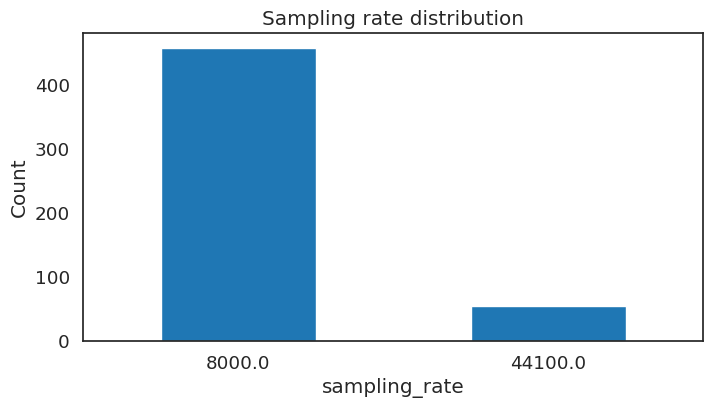

In [30]:
plt.figure(figsize=(8,4))
df["sampling_rate"].value_counts().sort_index().plot(kind="bar")
plt.title("Sampling rate distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


### Duration distribution

In [31]:
df["duration"].describe()

,duration
count,512.000000
mean,6.936537
std,0.227551
min,6.520000
25%,6.860000
50%,6.940000
75%,7.000000
max,8.730703


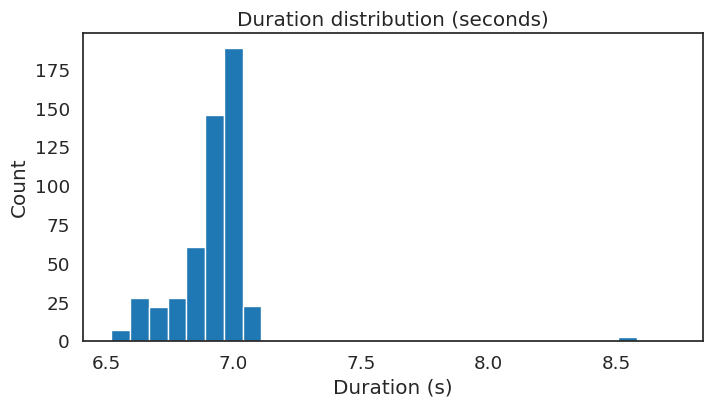

In [32]:
plt.figure(figsize=(8,4))
plt.hist(df["duration"], bins=30)
plt.title("Duration distribution (seconds)")
plt.xlabel("Duration (s)")
plt.ylabel("Count")
plt.show()


<Figure size 1000x500 with 0 Axes>

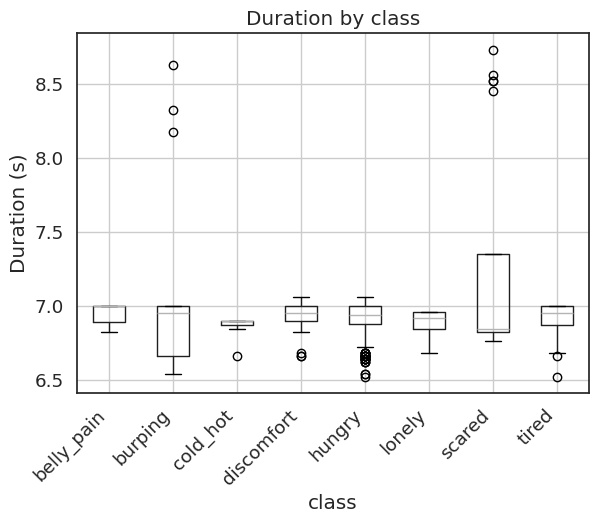

In [34]:
# Duration per class

plt.figure(figsize=(10,5))
df.boxplot(column="duration", by="class")
plt.title("Duration by class")
plt.suptitle("")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Duration (s)")
plt.show()


In [37]:
def plot_wave_and_mel(path, title=""):
    y, sr = librosa.load(path, sr=None)

    plt.figure(figsize=(12,3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {title} | sr={sr}, duration={len(y)/sr:.2f}s")
    plt.show()

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(12,4))
    librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
    plt.title(f"Mel Spectrogram (dB): {title}")
    plt.colorbar(format="%+2.0f dB")
    plt.show()


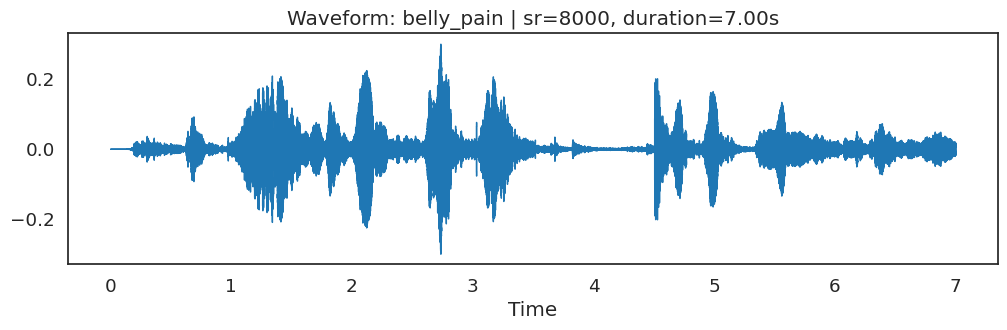

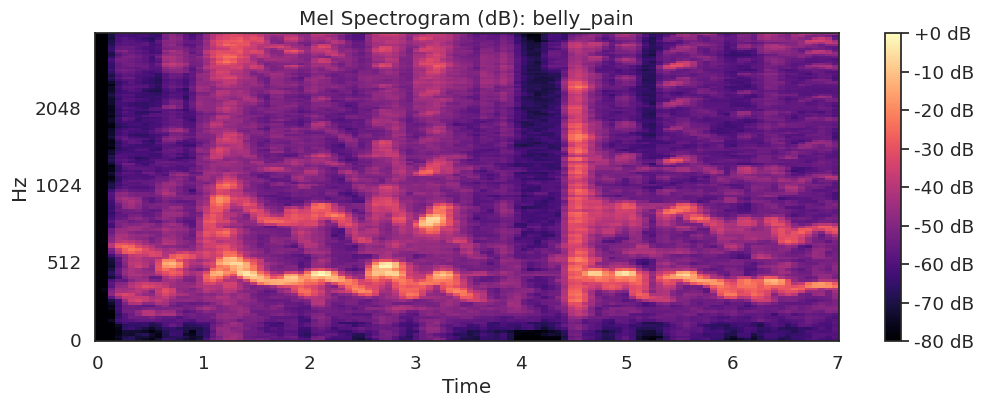

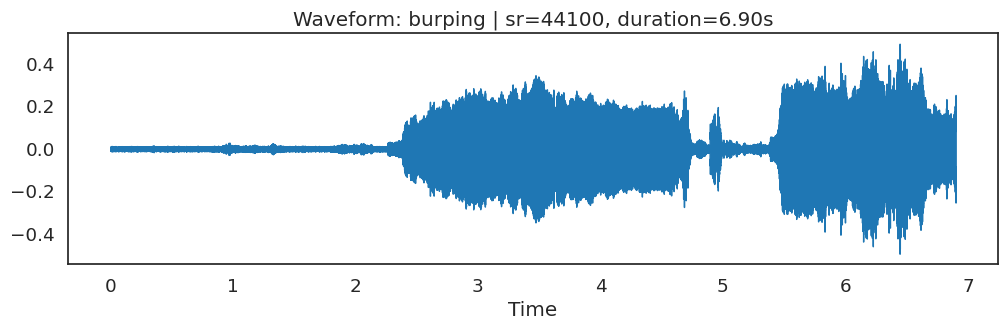

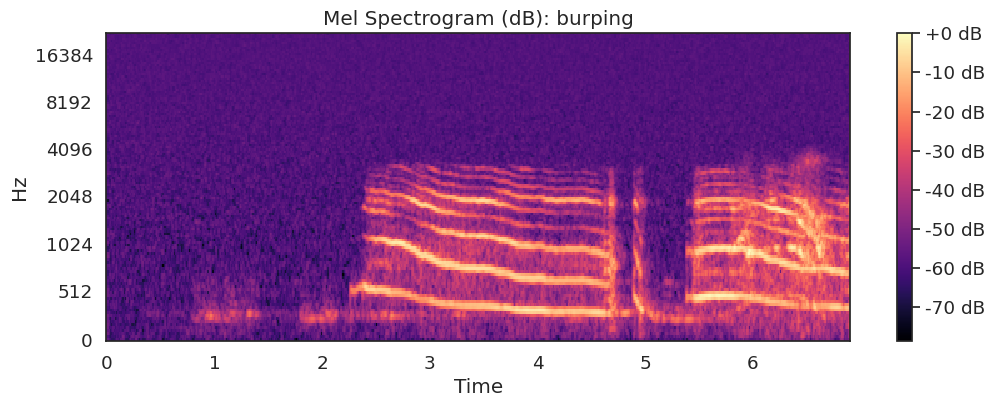

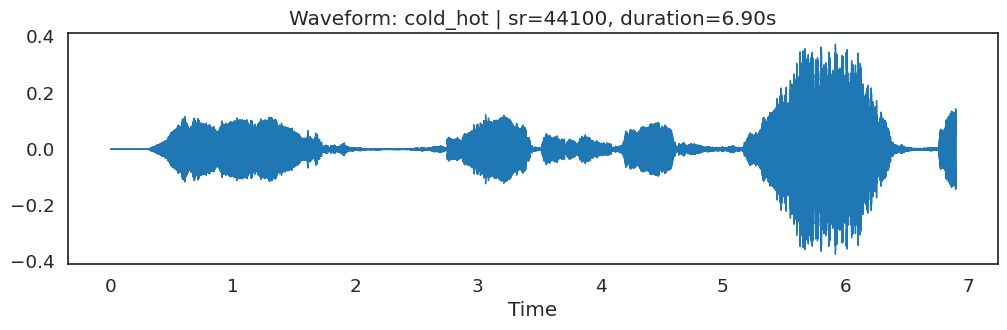

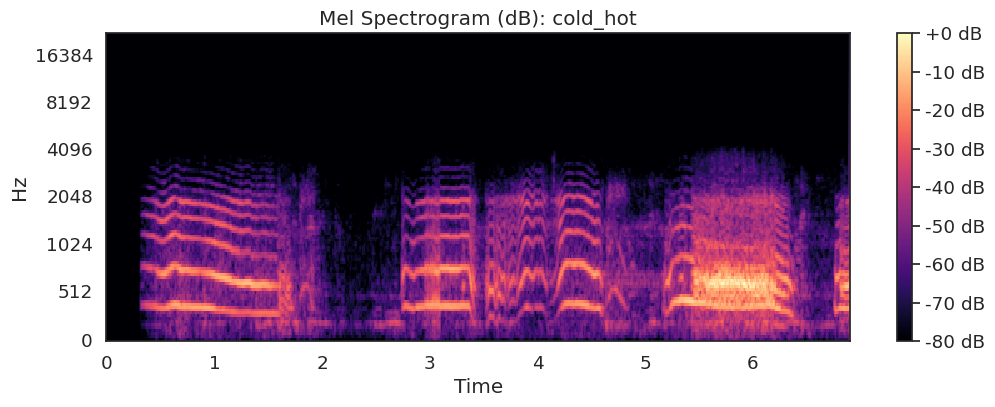

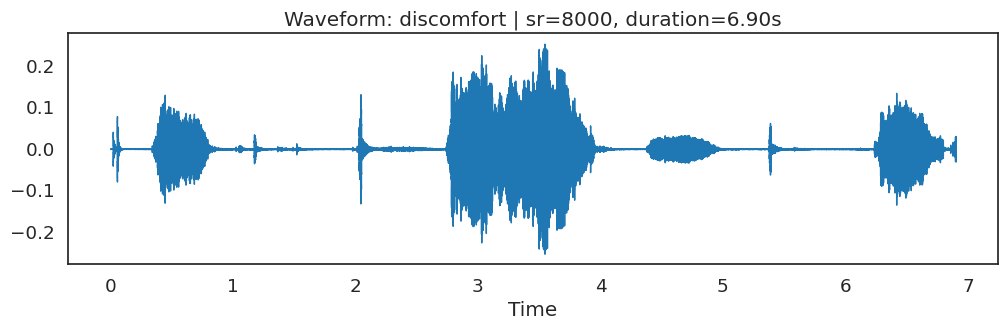

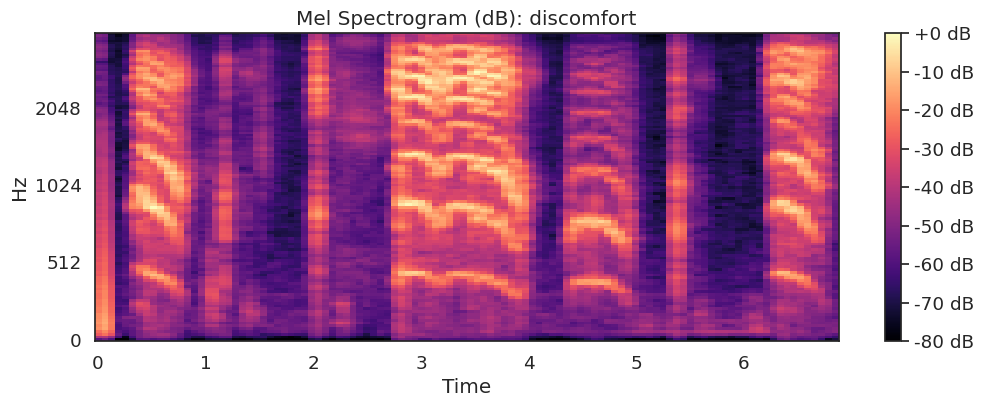

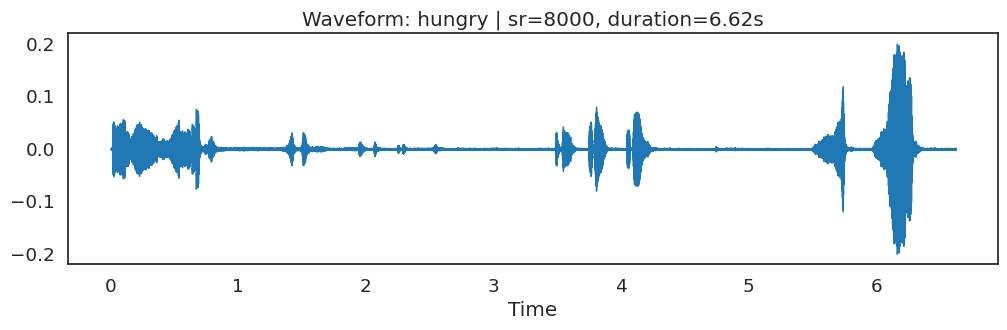

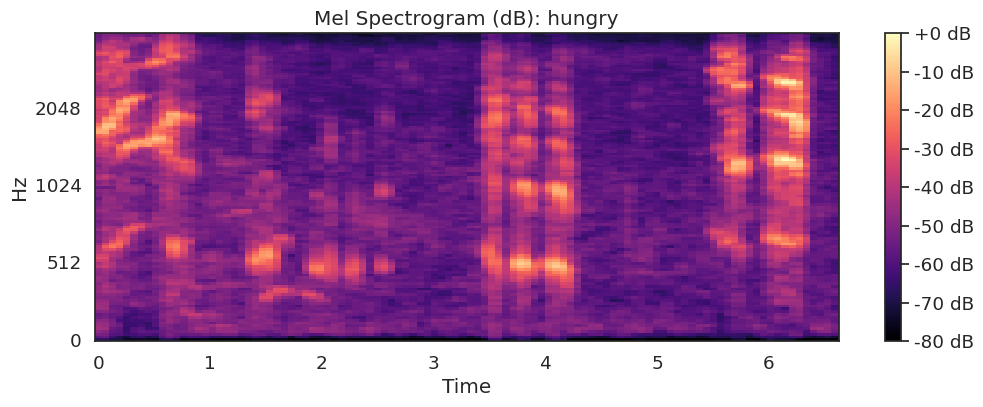

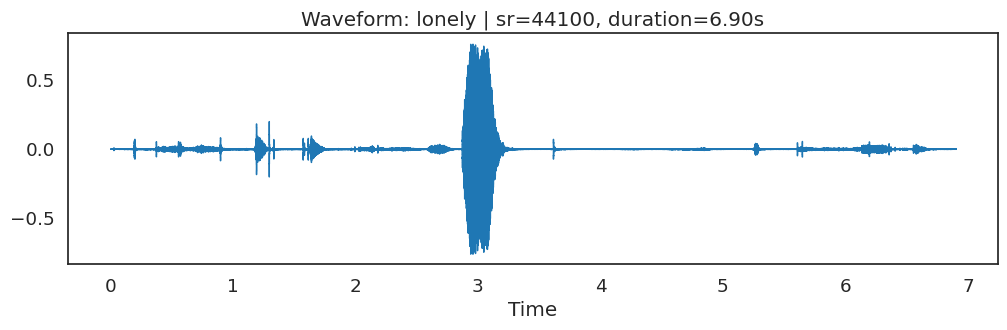

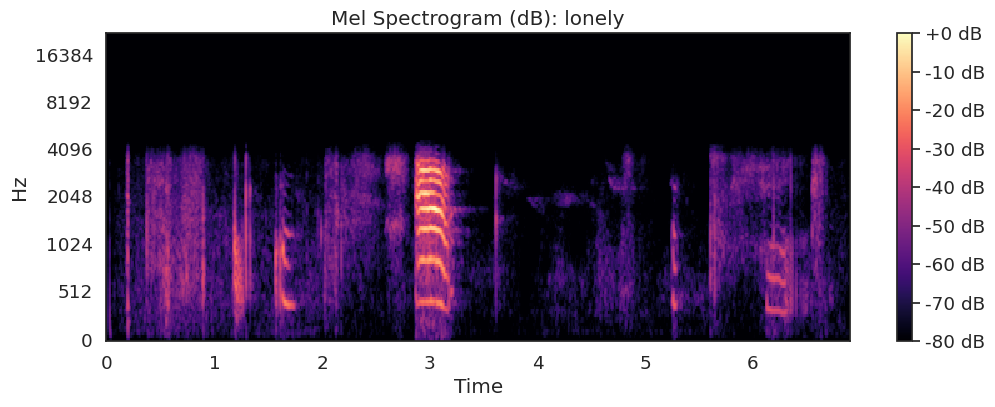

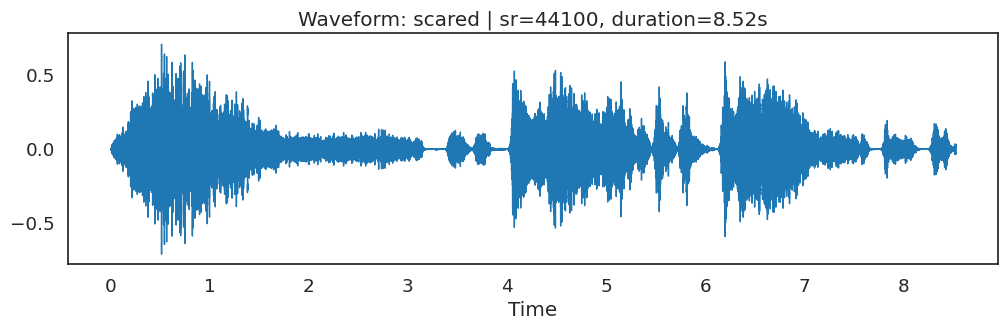

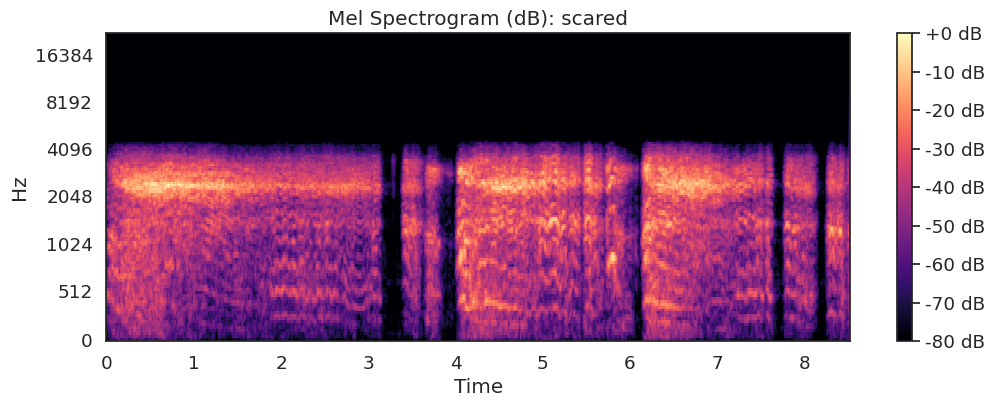

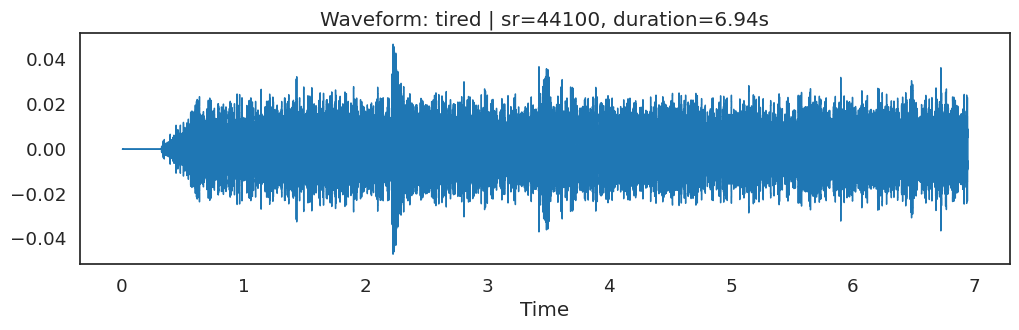

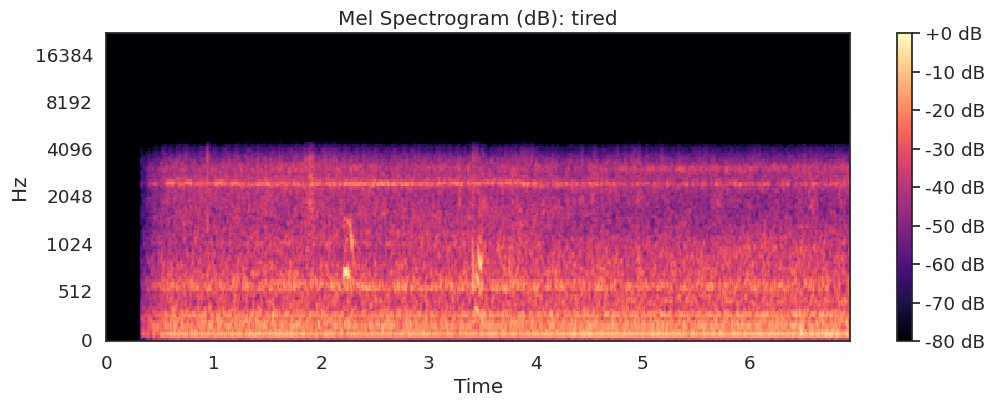

In [38]:
# plot one random file per class
for c in classes:
    sample_path = df[df["class"] == c].sample(1, random_state=1)["path"].iloc[0]
    plot_wave_and_mel(sample_path, title=c)


### Noise Detection

In [39]:
def rms_stats(path):
    y, sr = librosa.load(path, sr=None)
    rms = librosa.feature.rms(y=y)[0]
    return float(np.mean(rms)), float(np.std(rms))

rms_df = df["path"].apply(lambda p: pd.Series(rms_stats(p), index=["rms_mean","rms_std"]))
df2 = pd.concat([df, rms_df], axis=1)
df2[["rms_mean","rms_std"]].describe()


,rms_mean,rms_std
count,512.000000,512.000000
mean,0.070058,0.057486
std,0.062443,0.041179
min,0.000367,0.000306
25%,0.021294,0.023505
50%,0.054986,0.051677
75%,0.102433,0.083301
max,0.380196,0.210663


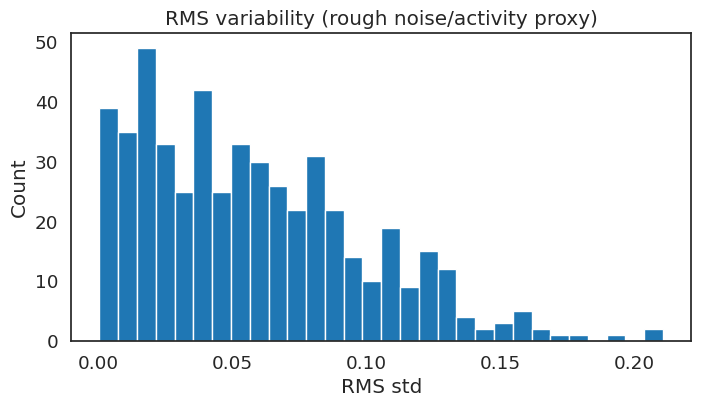

In [40]:
plt.figure(figsize=(8,4))
plt.hist(df2["rms_std"], bins=30)
plt.title("RMS variability (rough noise/activity proxy)")
plt.xlabel("RMS std")
plt.ylabel("Count")
plt.show()
